# Init

In [205]:
! pip install gamspy

In [206]:
! gamspy install license 204a1a5e-5e64-4583-a281-508165b2ee7e

In [207]:
import pandas as pd
from gamspy import Container, Set, Variable, Parameter, Equation, Sum, Model, Sense, Alias
import numpy as np
import itertools

# Data

In [208]:
# Load the CSV file into csv_data
csv_data = pd.read_csv("edge_distances_osrm.csv")

csv_data['valid'] = True
# Data for the arcs
data = {
    'Arc_Name': [
        'E18 North', 'E18 South', 'E20 East', '279 West', '275 West',
        'E20 South', '75 Mid', '73 South', '271 West', '222 East',
        '73 North', '75 East', '275 South', 'E4 South', '265 West',
        '275 North', 'E20 North'
    ],
    'Description': [
        'Täby to Bergshamra', 'Bergshamra to T-centralen', 'Lidingö to T-centralen',
        'Vällingby to Bergshamra', 'Vällingby to T-centralen', 'Skärholmen to Västberga',
        'Västberga to Globen', 'Farsta to Globen', 'Farsta to Skärholmen',
        'Nacka to T-centralen', 'Globen to T-centralen', 'Nacka to Globen',
        'Vällingby to Västberga', 'Sollentuna to Bergshamra', 'Sollentuna to Täby',
        'Vällingby to Sollentuna', 'Bergshamra to Västberga'
    ],
    'Lanes': [3, 6, 2, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 3, 1, 2, 3] #E18 South approx E4 and E18 in to city
}

# Create DataFrame
df_lanes = pd.DataFrame(data)
csv_data = pd.merge(csv_data, df_lanes, left_on='edge_name', right_on='Arc_Name', how='left')

In [209]:
csv_data['u_ij'] = csv_data['Lanes']*csv_data['distance_m']*4/5 #Approx 5m per car # Approx 4 person per car (Buses etc)

In [210]:
# Display the first few rows of the DataFrame
flipped_data = csv_data.copy()
flipped_data['from_node'], flipped_data['to_node'] = csv_data['to_node'], csv_data['from_node']

# Append the flipped data to the original to create an undirected graph
csv_data = pd.concat([csv_data, flipped_data], ignore_index=True)

csv_data

,edge_name,distance_m,duration_s,from_node,to_node,distance_km,duration_min,avg_speed_kmh,u_ij,a_ij,valid,Arc_Name,Description,Lanes
0,E18 North,9333.6,628.5,Täby,Bergshamra,9.3336,10.475000,53.462148,22400.64,3.182180,True,E18 North,Täby to Bergshamra,3
1,E18 South,8989.9,704.5,Bergshamra,T-Centralen,8.9899,11.741667,45.938453,43151.52,2.838893,True,E18 South,Bergshamra to T-centralen,6
2,E20 East,8025.1,857.8,Lidingö,T-Centralen,8.0251,14.296667,33.679599,12840.16,2.331546,True,E20 East,Lidingö to T-centralen,2
3,279 West,15364.8,1137.2,Vällingby,Bergshamra,15.3648,18.953333,48.639887,24583.68,1.055223,True,279 West,Vällingby to Bergshamra,2
4,275 West,13454.3,1302.3,Vällingby,T-Centralen,13.4543,21.705000,37.192260,21526.88,0.921447,True,275 West,Vällingby to T-centralen,2
5,E20 South,8900.0,623.6,Skärholmen,Årstaberg,8.9000,10.393333,51.379089,21360.00,3.207184,True,E20 South,Skärholmen to Västberga,3
6,75 Mid,4200.4,312.2,Årstaberg,Avicii Arena,4.2004,5.203333,48.435106,6720.64,2.562460,True,75 Mid,Västberga to Globen,2
7,73 South,9457.5,856.9,Farsta Shopping Centre,Avicii Arena,9.4575,14.281667,39.732758,15132.00,0.933598,True,73 South,Farsta to Globen,2
8,271 West,14464.8,1215.1,Skärholmen,Farsta Shopping Centre,14.4648,20.251667,42.855139,11571.84,0.987573,True,271 West,Farsta to Skärholmen,1
9,222 East,9847.3,855.9,Nacka Forum,T-Centralen,9.8473,14.265000,41.418717,15755.68,1.402033,True,222 East,Nacka to T-centralen,2


### Demand split

In [211]:
# Chat Gpt generated
# Construct the DataFrame
data = {
    "Node": [
        "Farsta Shopping Centre", "Skärholmen", "Vällingby", "Täby", "Lidingö",
        "Nacka Forum", "Sollentuna", "Bergshamra", "Avicii Arena", "Årstaberg", "T-Centralen"
    ],
    "Approx. Population": [
        60_523, 33_662, 71_042, 77_744, 48_162, 110_633, 76_237, 7_300, 70_779, 12_486, 40_312
    ],
    "Source": [
        "Farsta borough (2022 estimate)",
        "Skärholmen borough (2004)",
        "Hässelby-Vällingby borough (2014)",
        "Täby Municipality (31 Dec 2024)",
        "Lidingö urban area (2023)",
        "Nacka Municipality (2023)",
        "Sollentuna Municipality (2022)",
        "Bergshamra suburb (approx.)",
        "Östermalm borough (2014)",
        "Årsta locality (recent)",
        "Norrmalm district"
    ]
}

_df = pd.DataFrame(data)

_df["Working Commuters"] = _df["Approx. Population"] * 0.5 * 0.5 # 50% of the population are commuting, and 60% of them commute with cars


In [212]:
_init = np.diag(_df["Working Commuters"].to_numpy())
skew = 0.9

d, _ = _init.shape

for i in range(d):
    pop = _init[i,i]
    if i != d-1:
        r_pop = int(pop*(1-skew)/(d-2))
        t_pop = pop-r_pop*(d-2)

        # Set everything to r_pop
        _init[:, i] = -r_pop

        # Restore the i-th value (keep it the same as before)
        _init[i, i] = pop

        # Set the last value to t_pop
        _init[-1, i] = -t_pop
    else:
        r_pop = int(pop/(d-1))
        t_pop = r_pop*(d-1)

        # Set everything to r_pop
        _init[:, i] = -r_pop

        # Set the last value to t_pop
        _init[-1, i] = t_pop

_init = _init.astype(int)

df_init = pd.DataFrame(_init, index=data['Node'], columns=data['Node'])

In [213]:
df_flow = df_init.melt(ignore_index=False).reset_index().rename(columns={"index": "Node", "variable": "Origin Flow", 0: "Distance"}).dropna().set_index(["Node", "Origin Flow"]).sort_index().reset_index()
df_flow.head(20)

,Node,Origin Flow,value
0,Avicii Arena,Avicii Arena,17694
1,Avicii Arena,Bergshamra,-20
2,Avicii Arena,Farsta Shopping Centre,-168
3,Avicii Arena,Lidingö,-133
4,Avicii Arena,Nacka Forum,-307
5,Avicii Arena,Skärholmen,-93
6,Avicii Arena,Sollentuna,-211
7,Avicii Arena,T-Centralen,-1007
8,Avicii Arena,Täby,-215
9,Avicii Arena,Vällingby,-197


# Masking the Set

In [214]:
# Create all possible combinations of from_node and to_node
all_combinations = list(itertools.product(data['Node'], data['Node']))
result_df = pd.DataFrame(all_combinations, columns=['from_node', 'to_node'])

# Create a set of tuples from the original DataFrame for quick lookup
existing_pairs = set(zip(csv_data['from_node'], csv_data['to_node']))

# Add a column 'value' where 1 indicates the pair exists in csv_data, 0 otherwise
result_df['value'] = result_df.apply(lambda row: 1 if (row['from_node'], row['to_node']) in existing_pairs or (row['to_node'], row['from_node']) in existing_pairs else 0, axis=1)

# Display the resulting DataFrame
print(result_df['value'].sum())

34


# Problem 2 (1 is the KML files)

## Modeling

In [215]:
m = Container()

In [216]:
on_Node = Set(m, "from_Node", records=_df["Node"].tolist())
to_Node = Alias(m, "to_Node", on_Node)
Com_from = Alias(m, "Comuter_from", on_Node)

In [217]:
Flows = Parameter(m, "flows", domain=[on_Node, Com_from], description="the flow at Node for each commuter from Nodes_", records=df_flow[["Node", "Origin Flow", "value"]])
Valid_flows = Parameter(m, "valid_flows", domain=[on_Node, to_Node], description="the allowed flow at each Node for each commuter from Nodes_", records=result_df[["from_node", "to_node", "value"]])
Road_times = Parameter(m, "road_time", domain=[on_Node, to_Node], description="Time to travel on the road", records=csv_data[["from_node", "to_node", "duration_min"]])

In [218]:
Road_util = Variable(m, "road_util", domain=[on_Node, to_Node, Com_from], type='positive', description="Roads to be used by commuter from node")

In [219]:
Flow_parity = Equation(m, "flow_parity", domain=[on_Node, Com_from], description="Flow parity equation")

Flow_parity[on_Node, Com_from] = (
    Sum(to_Node, Valid_flows[on_Node, to_Node]*(Road_util[on_Node, to_Node, Com_from])) - Sum(to_Node, Valid_flows[on_Node, to_Node]*(Road_util[to_Node, on_Node, Com_from])) == Flows[on_Node, Com_from]
)

In [220]:
obj = (Sum((on_Node, to_Node),
     Road_times[on_Node, to_Node] 
     * Sum(Com_from, Road_util[on_Node, to_Node, Com_from])) 
     / Sum((Com_from), Flows[Com_from, Com_from])) # Average time for each car

In [221]:
LP = Model(m, equations=m.getEquations(), sense=Sense.MIN, objective=obj, name="LP")
LP.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,19.0251995952907,122,375,MIP,CPLEX,0.002


In [222]:
ru = Road_util.records
ru

,from_Node,to_Node,Comuter_from,level,marginal,lower,upper,scale
0,Farsta Shopping Centre,Skärholmen,Farsta Shopping Centre,168.0,0.000000,0.0,inf,1.0
1,Farsta Shopping Centre,Skärholmen,Skärholmen,0.0,0.000266,0.0,inf,1.0
2,Farsta Shopping Centre,Skärholmen,Vällingby,0.0,0.000193,0.0,inf,1.0
3,Farsta Shopping Centre,Skärholmen,Täby,0.0,0.000182,0.0,inf,1.0
4,Farsta Shopping Centre,Skärholmen,Lidingö,0.0,0.000124,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
369,T-Centralen,Avicii Arena,Sollentuna,422.0,0.000000,0.0,inf,1.0
370,T-Centralen,Avicii Arena,Bergshamra,40.0,0.000000,0.0,inf,1.0
371,T-Centralen,Avicii Arena,Avicii Arena,0.0,0.000103,0.0,inf,1.0
372,T-Centralen,Avicii Arena,Årstaberg,0.0,0.000103,0.0,inf,1.0


In [223]:
sol_flows = ru[(ru["Comuter_from"] == "Lidingö") & ~((ru["level"] == 0) & (ru["marginal"] != 0))].drop(columns=["Comuter_from"])
sol_flows

,from_Node,to_Node,level,marginal,lower,upper,scale
114,Lidingö,T-Centralen,12040.0,0.0,0.0,inf,1.0
191,Bergshamra,Täby,133.0,0.0,0.0,inf,1.0
202,Bergshamra,Sollentuna,133.0,0.0,0.0,inf,1.0
235,Avicii Arena,Farsta Shopping Centre,133.0,0.0,0.0,inf,1.0
257,Avicii Arena,Årstaberg,266.0,0.0,0.0,inf,1.0
279,Årstaberg,Skärholmen,133.0,0.0,0.0,inf,1.0
323,T-Centralen,Vällingby,133.0,0.0,0.0,inf,1.0
345,T-Centralen,Nacka Forum,133.0,0.0,0.0,inf,1.0
356,T-Centralen,Bergshamra,399.0,0.0,0.0,inf,1.0
367,T-Centralen,Avicii Arena,532.0,0.0,0.0,inf,1.0


In [224]:
all_flows = ru.groupby(["from_Node", "to_Node"])['level'].sum().reset_index()
all_flows

/tmp/ipykernel_4448/4013698234.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_flows = ru.groupby(["from_Node", "to_Node"])['level'].sum().reset_index()


,from_Node,to_Node,level
0,Farsta Shopping Centre,Farsta Shopping Centre,0.0
1,Farsta Shopping Centre,Skärholmen,168.0
2,Farsta Shopping Centre,Vällingby,0.0
3,Farsta Shopping Centre,Täby,0.0
4,Farsta Shopping Centre,Lidingö,0.0
...,...,...,...
116,T-Centralen,Sollentuna,0.0
117,T-Centralen,Bergshamra,5433.0
118,T-Centralen,Avicii Arena,5452.0
119,T-Centralen,Årstaberg,0.0


## Plotting

In [225]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import contextily as ctx
from shapely.geometry import Point, LineString
from pykml import parser
import numpy as np

def plot_flow_network(df):
    # Path to the KML file (update if necessary)
    kml_file_path = "Nodes.kml"

    # Parse KML to extract coordinates and names
    def parse_kml(file_path):
        with open(file_path, 'r') as f:
            kml_obj = parser.parse(f).getroot()
        coords_dict = {}
        labels_dict = {}
        for placemark in kml_obj.Document.Placemark:
            name = placemark.name.text
            labels_dict[name] = name  # Use Placemark name as label
            coords = placemark.Point.coordinates.text.strip().split(',')
            lon, lat = float(coords[0]), float(coords[1])
            coords_dict[name] = (lon, lat)
        return coords_dict, labels_dict

    coords, node_labels = parse_kml(kml_file_path)

    # Filter to include only positive flows
    positive_flows = df[df['level'] > 0].copy()

    # Create GeoDataFrame for nodes
    nodes = pd.DataFrame({
        'name': list(coords.keys()),
        'geometry': [Point(lon, lat) for lon, lat in coords.values()]
    })
    nodes_gdf = gpd.GeoDataFrame(nodes, geometry='geometry', crs="EPSG:4326")

    # Create GeoDataFrame for arcs
    arcs = []
    for _, row in positive_flows.iterrows():
        from_node = row['from_Node']
        to_node = row['to_Node']
        if from_node in coords and to_node in coords:
            line = LineString([Point(coords[from_node]), Point(coords[to_node])])
            arcs.append({
                'from_node': from_node,
                'to_node': to_node,
                'level': row['level'],
                'geometry': line
            })

    arcs_gdf = gpd.GeoDataFrame(arcs, geometry='geometry', crs="EPSG:4326")

    # Project to Web Mercator for compatibility with basemap
    nodes_gdf = nodes_gdf.to_crs(epsg=3857)
    arcs_gdf = arcs_gdf.to_crs(epsg=3857)

    # Calculate line widths based on level
    max_level = arcs_gdf['level'].max()
    arcs_gdf['linewidth'] = arcs_gdf['level'].apply(lambda x: 1 + 4 * x / max_level)  # Scale 1 to 5

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot arcs
    arcs_gdf.plot(ax=ax, linewidth=arcs_gdf['linewidth'], color='blue', alpha=0.6)

    # Add arrows with perpendicular offset and place flow level labels on them
    offset_distance = 500  # Offset distance in meters for arrows
    for idx, row in arcs_gdf.iterrows():
        coords = list(row.geometry.coords)
        start_x, start_y = coords[0]
        end_x, end_y = coords[-1]
        dx = end_x - start_x
        dy = end_y - start_y
        length = np.sqrt(dx**2 + dy**2)
        if length == 0:
            continue  # Skip zero-length arcs
        
        # Calculate position for the arrow (closer to the middle)
        t = 0.7  # Place arrow at 70% along the line
        base_x = start_x + t * (end_x - start_x)
        base_y = start_y + t * (end_y - start_y)
        
        # Compute perpendicular vector for offset
        perp_x = -dy / length
        perp_y = dx / length
        
        # Determine offset direction based on node order
        from_node = row['from_node']
        to_node = row['to_node']
        offset_direction = 1 if from_node < to_node else -1
        
        # Apply offset to arrow position
        offset_x = perp_x * offset_distance * offset_direction
        offset_y = perp_y * offset_distance * offset_direction
        arrow_x = base_x + offset_x
        arrow_y = base_y + offset_y
        
        # Adjust arrow direction to align with arc
        arrow_dx = (end_x - start_x) * 0.1 / length  # Scale to match original arrow length
        arrow_dy = (end_y - start_y) * 0.1 / length
        
        # Add offset arrow
        arrow = FancyArrowPatch(
            (arrow_x, arrow_y),
            (arrow_x + arrow_dx * length, arrow_y + arrow_dy * length),
            arrowstyle='->',
            mutation_scale=15,
            linewidth=row['linewidth'],
            color='blue',
            alpha=0.6
        )
        ax.add_patch(arrow)

        # Place the flow level label at the arrow's starting position, slightly offset
        label_offset_distance = 200  # Small offset to avoid overlapping the arrowhead
        label_x = arrow_x + perp_x * label_offset_distance * offset_direction
        label_y = arrow_y + perp_y * label_offset_distance * offset_direction
        ax.text(
            label_x,
            label_y,
            str(int(row['level'])),
            fontsize=8,
            color='darkblue',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    # Plot nodes with increased size
    nodes_gdf.plot(ax=ax, color='red', markersize=150, zorder=2)

    # Add node labels
    for idx, row in nodes_gdf.iterrows():
        label = node_labels.get(row['name'], row['name'])
        ax.annotate(
            label,
            xy=(row.geometry.x, row.geometry.y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

    # Set title and adjust plot
    ax.set_title("Commuter Flows on Stockholm Map", fontsize=14, pad=10)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

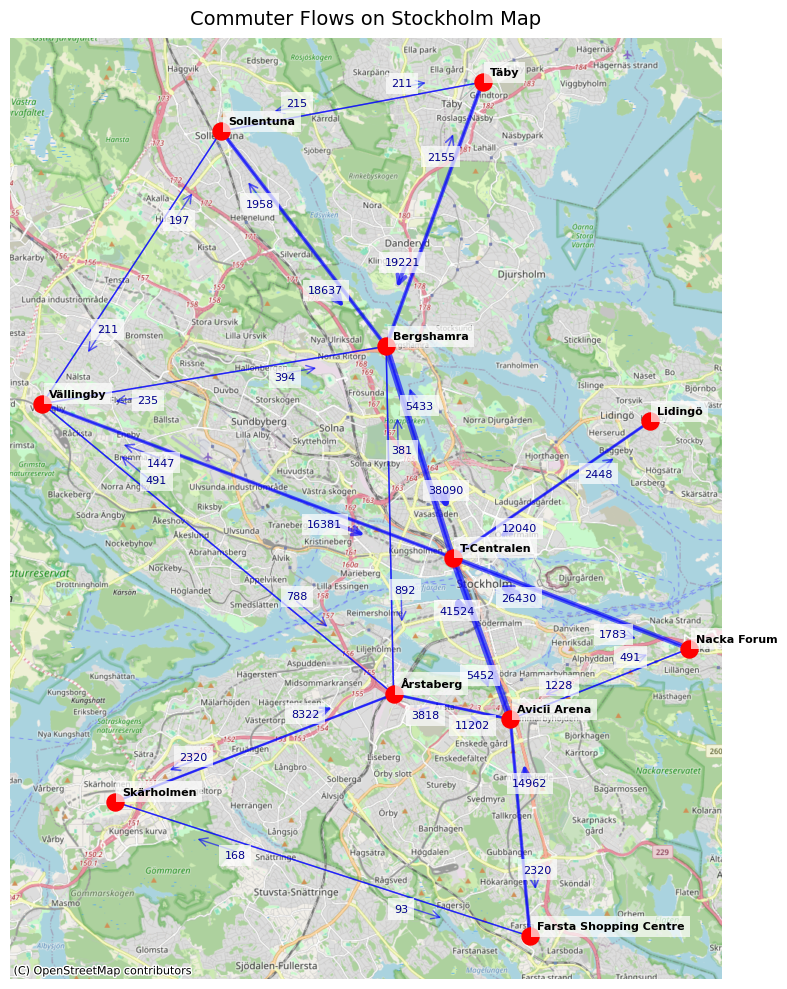

In [226]:
plot_flow_network(all_flows)

In [227]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString
from heapq import heappush, heappop

# Create undirected graph: adjacency list of (node, duration_min)
nodes = set(csv_data["from_node"]).union(set(csv_data["to_node"]))
graph = {node: [] for node in nodes}
for _, row in csv_data.iterrows():
    graph[row["from_node"]].append((row["to_node"], row["duration_min"]))
    graph[row["to_node"]].append((row["from_node"], row["duration_min"]))  # Add reverse edge for undirected graph

# Dijkstra's algorithm
def dijkstra(graph, start):
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    predecessors = {node: None for node in graph}
    pq = [(0, start)]
    while pq:
        current_distance, current_node = heappop(pq)
        if current_distance > distances[current_node]:
            continue
        for neighbor, weight in graph[current_node]:
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_node
                heappush(pq, (distance, neighbor))
    return distances, predecessors

# Get shortest paths
def get_path(predecessors, end):
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessors[current]
    return path[::-1]

def plot_closest_path(start_node):
    distances, predecessors = dijkstra(graph, start_node)
    shortest_paths = {}
    for node in nodes:
        if distances[node] != float('inf'):
            path = get_path(predecessors, node)
            shortest_paths[node] = {"duration_min": distances[node], "path": path}

    # Print shortest paths
    print(f"Shortest Paths from {start_node} (by Duration):")
    for node, info in sorted(shortest_paths.items()):  # Sort for consistent output
        print(f"To {node}:")
        print(f"  Duration: {info['duration_min']:.2f} minutes")
        print(f"  Path: {' -> '.join(info['path'])}")

    # Create GeoDataFrame for shortest paths
    path_arcs = []
    for node, info in shortest_paths.items():
        if node != start_node:  # Exclude the starting node
            path = info["path"]
            for i in range(len(path) - 1):
                from_node = path[i]
                to_node = path[i + 1]
                if from_node in coords and to_node in coords:
                    line = LineString([Point(coords[from_node]), Point(coords[to_node])])
                    path_arcs.append({
                        "from_node": from_node,
                        "to_node": to_node,
                        "destination": node,
                        "geometry": line
                    })

    paths_gdf = gpd.GeoDataFrame(path_arcs, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

    # Create GeoDataFrame for all edges (for context)
    arcs = []
    for _, row in csv_data.iterrows():
        if row["from_node"] in coords and row["to_node"] in coords:
            line = LineString([Point(coords[row["from_node"]]), Point(coords[row["to_node"]])])
            arcs.append({"geometry": line})
    arcs_gdf = gpd.GeoDataFrame(arcs, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

    # Create GeoDataFrame for nodes
    nodes_gdf = gpd.GeoDataFrame(
        {"name": list(coords.keys()), "geometry": [Point(lon, lat) for lon, lat in coords.values()]},
        geometry='geometry', crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 10))
    arcs_gdf.plot(ax=ax, color='gray', alpha=0.3, linewidth=1)  # All edges in faint gray
    paths_gdf.plot(ax=ax, color='blue', linewidth=2, alpha=0.8)  # Shortest paths in blue
    nodes_gdf.plot(ax=ax, color='red', markersize=100, zorder=2)  # Nodes in red

    # Add node labels
    for idx, row in nodes_gdf.iterrows():
        ax.annotate(
            row['name'],
            xy=(row.geometry.x, row.geometry.y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

    # Set title and adjust plot
    ax.set_title(f"Shortest Paths from {start_node} by Duration to All Nodes", fontsize=14, pad=10)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

Shortest Paths from Lidingö (by Duration):
To Avicii Arena:
  Duration: 22.16 minutes
  Path: Lidingö -> T-Centralen -> Avicii Arena
To Bergshamra:
  Duration: 26.04 minutes
  Path: Lidingö -> T-Centralen -> Bergshamra
To Farsta Shopping Centre:
  Duration: 36.44 minutes
  Path: Lidingö -> T-Centralen -> Avicii Arena -> Farsta Shopping Centre
To Lidingö:
  Duration: 0.00 minutes
  Path: Lidingö
To Nacka Forum:
  Duration: 28.56 minutes
  Path: Lidingö -> T-Centralen -> Nacka Forum
To Skärholmen:
  Duration: 37.76 minutes
  Path: Lidingö -> T-Centralen -> Avicii Arena -> Årstaberg -> Skärholmen
To Sollentuna:
  Duration: 38.44 minutes
  Path: Lidingö -> T-Centralen -> Bergshamra -> Sollentuna
To T-Centralen:
  Duration: 14.30 minutes
  Path: Lidingö -> T-Centralen
To Täby:
  Duration: 36.51 minutes
  Path: Lidingö -> T-Centralen -> Bergshamra -> Täby
To Vällingby:
  Duration: 36.00 minutes
  Path: Lidingö -> T-Centralen -> Vällingby
To Årstaberg:
  Duration: 27.36 minutes
  Path: Liding

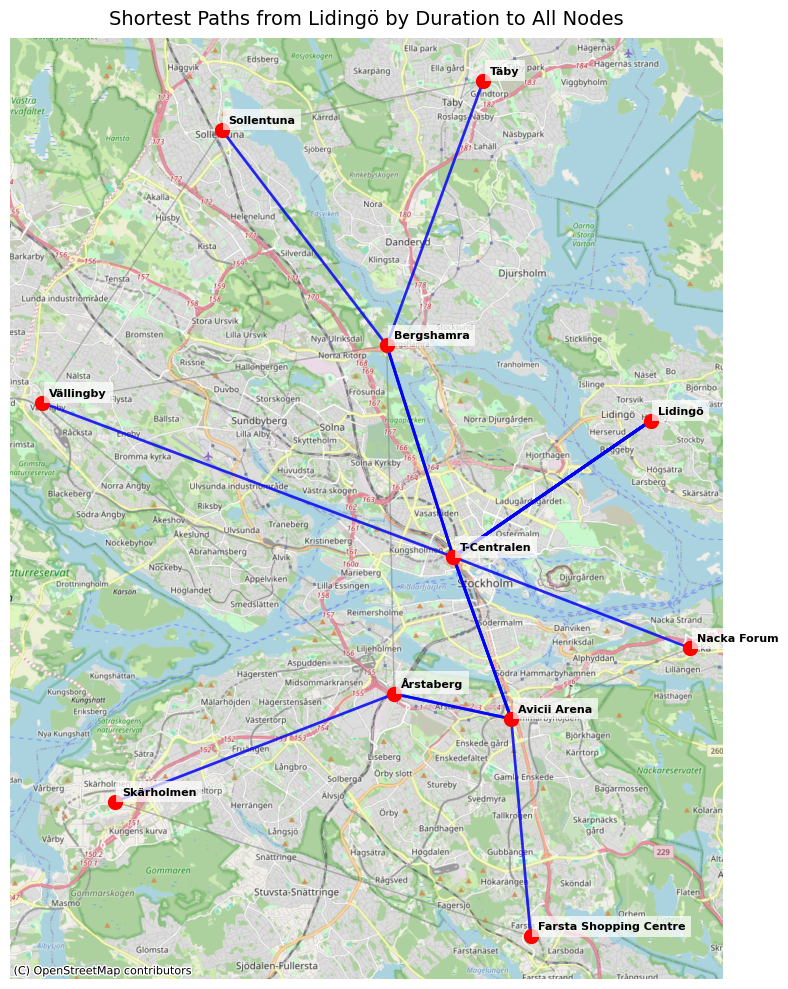

In [228]:
plot_closest_path("Lidingö")

# Problem 3 